In [3]:
#Hide Warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

__Things to add in this notebook__
- links to other repos using pvlib.

# Pvlib Library

Written by __[Somil Singhai](https://www.linkedin.com/in/ss1804)__ on 29 December 2018.

__Note__: A lot of codes have been copied from the official documentation. I have just compiled them here for quick referance!

A number of Example Python notebooks and examples are available.
-  Example [Jupyter notebooks](https://nbviewer.jupyter.org/github/pvlib/pvlib-python/tree/master/docs/tutorials/) available.
-  [Projects and Publications](https://github.com/pvlib/pvlib-python/wiki/Projects-and-publications-that-use-pvlib-python) that use pvlib python.
-  [Variable naming](https://pvlib-python.readthedocs.io/en/latest/variables_style_rules.html#variables-style-rules) convention to ensure consistency throughout the library.

In [4]:
#Importing the pvlib library
import pvlib
print('pvlib version :', pvlib.__version__)

pvlib version : 0.6.0


In [5]:
#To get solar Position
#solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

In [6]:
# dni_extra = pvlib.irradiance.get_extra_radiation(times)

In [7]:
#airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
#pressure = pvlib.atmosphere.alt2pres(altitude)
#am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

## Calculating yearly energy yield
for a given hardware configuration

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

naive_times = pd.DatetimeIndex(start='2015', end='2016', freq='1h')

# very approximate
# latitude, longitude, name, altitude, timezone
coordinates = [(30, -110, 'Tucson', 700, 'Etc/GMT+7'),
                (35, -105, 'Albuquerque', 1500, 'Etc/GMT+7'),
                (40, -120, 'San Francisco', 10, 'Etc/GMT+8'),
                (50, 10, 'Berlin', 34, 'Etc/GMT-1')]

import pvlib

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
# specify constant ambient air temp and wind for simplicity
temp_air = 20

wind_speed = 0

The following code demonstrates how to use the procedural code to accomoplish our system modeling goal.

__Insights__
- Need to get the corresponding plant inverter model.
- pd.tz_localize(_timezone_) is used to add timezone attribute to the pd time series.
- `pvlib.irradiance.get_extra_radiation` :     Determine extraterrestrial radiation from day of year.
- [Zenith](https://en.wikipedia.org/wiki/Zenith) angle.
- `pvlib.irradiance.aoi` - angle of incidence of solar vector.
- `irradiance.get_total_irradiance` - takes a lot of parameters. [Refer](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.irradiance.get_total_irradiance.html) here.
- Sandia Photovoltaic Array Performance model.



Tucson           467740.0
Albuquerque      500451.0
San Francisco    440046.0
Berlin           383547.0
dtype: float64 



Text(0, 0.5, 'Yearly energy yield (W hr)')

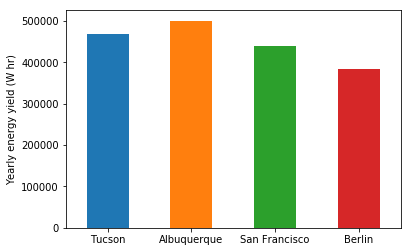

In [9]:
system = {'module': module, 'inverter': inverter,
         'surface_azimuth': 180}


energies = {}

for latitude, longitude, name, altitude, timezone in coordinates:
    times = naive_times.tz_localize(timezone)
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
    dni_extra = pvlib.irradiance.get_extra_radiation(times)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
    cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                                  dni_extra=dni_extra, altitude=altitude)
    aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                                solpos['apparent_zenith'], solpos['azimuth'])
    total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                         system['surface_azimuth'],
                                                         solpos['apparent_zenith'],
                                                         solpos['azimuth'],
                                                         cs['dni'], cs['ghi'], cs['dhi'],
                                                         dni_extra=dni_extra,
                                                         model='haydavies')
    temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
                                          wind_speed, temp_air)
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
         total_irrad['poa_direct'], total_irrad['poa_diffuse'],
         am_abs, aoi, module)
    dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
    ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy

energies = pd.Series(energies)

print(energies.round(0),'\n')
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')

## Object Oriented Approach

Use of `Location`,`PVSystem`,`ModelChain`.

Tucson           467704.0
Albuquerque      500372.0
San Francisco    440046.0
Berlin           383544.0
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

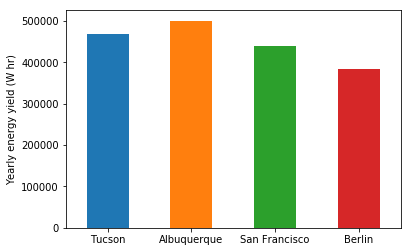

In [10]:
from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain

system = PVSystem(module_parameters=module,
                  inverter_parameters=inverter)


energies = {}

for latitude, longitude, name, altitude, timezone in coordinates:
    times = naive_times.tz_localize(timezone)
    location = Location(latitude, longitude, name=name, altitude=altitude,
                            tz=timezone)
    mc = ModelChain(system, location,
                       orientation_strategy='south_at_latitude_tilt')
    mc.run_model(times)
    annual_energy = mc.ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)

print(energies.round(0))
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')

__Insights__:
- Ineichen and Perez clear sky model: `pvlib.clearsky.ineichen` - returns DNI, GHI, etc. [link](https://pvlib-python.readthedocs.io/en/latest/_modules/pvlib/clearsky.html)

### Locallized PV system
`LocalizedPVSystem()`

Text(0, 0.5, 'Yearly energy yield (W hr)')

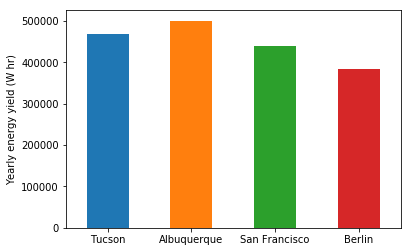

In [11]:
from pvlib.pvsystem import LocalizedPVSystem

energies = {}

for latitude, longitude, name, altitude, timezone in coordinates:
    localized_system = LocalizedPVSystem(module_parameters=module,
                                         inverter_parameters=inverter,
                                         surface_tilt=latitude,
                                         surface_azimuth=180,
                                         latitude=latitude,
                                         longitude=longitude,
                                         name=name,
                                         altitude=altitude,
                                         tz=timezone)
    times = naive_times.tz_localize(timezone)
    clearsky = localized_system.get_clearsky(times)
    solar_position = localized_system.get_solarposition(times)
    total_irrad = localized_system.get_irradiance(solar_position['apparent_zenith'],
                                                  solar_position['azimuth'],
                                                  clearsky['dni'],
                                                  clearsky['ghi'],
                                                  clearsky['dhi'])
    temps = localized_system.sapm_celltemp(total_irrad['poa_global'],
                                           wind_speed, temp_air)
    aoi = localized_system.get_aoi(solar_position['apparent_zenith'],
                                   solar_position['azimuth'])
    airmass = localized_system.get_airmass(solar_position=solar_position)
    effective_irradiance = localized_system.sapm_effective_irradiance(
        total_irrad['poa_direct'], total_irrad['poa_diffuse'],
        airmass['airmass_absolute'], aoi)
    dc = localized_system.sapm(effective_irradiance, temps['temp_cell'])
    ac = localized_system.snlinverter(dc['v_mp'], dc['p_mp'])
    annual_energy = ac.sum()
    energies[name] = annual_energy

energies = pd.Series(energies)
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')


## `pvsystem.PVSystem()`
[link](https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.PVSystem.html#pvlib.pvsystem.PVSystem) for documentation.
[Reference](https://pvlib-python.readthedocs.io/en/latest/pvsystem.html)

Two types of data stored in object.
- Intrinsic data: Example- the data that describes a PV system’s module parameters is stored in `PVSystem.module_parameters`.
- Extrinsic data: passed to a PVSystem as method arguments. For example, the `pvwatts_dc()` method accepts extrinsic data irradiance and temperature.

Multiple methods may pull data from the same attribute. For example, the PVSystem.module_parameters attribute is used by the DC model methods as well as the incidence angle modifier methods.

In [12]:
# Intrinsic Data storage
from pvlib import pvsystem
module_parameters = {'pdc0': 10, 'gamma_pdc': -0.004}

system = pvsystem.PVSystem(module_parameters=module_parameters)

print(system.module_parameters)

pdc = system.pvwatts_dc(1000, 30)

print('\n',pdc)

{'pdc0': 10, 'gamma_pdc': -0.004}

 9.8


## `ModelChain()`
- A ModelChain is composed of a PVSystem object and a Location object

__Examples__

In [13]:
import pandas as pd

import numpy as np

# pvlib imports
import pvlib

from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain

#load some module and inverter specifications
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

Now we create a `Location` object, a PVSystem object and a `ModelChain` object

In [18]:
location = Location(latitude=32.2, longitude=-110.9)

system = PVSystem(surface_tilt=20, surface_azimuth=200,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)

mc = ModelChain(system, location)
print(mc)

weather = pd.DataFrame([[1050, 1000, 100, 30, 5]],
                       columns=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'],
                       index=[pd.Timestamp('20170401 1200', tz='US/Arizona')])


mc.run_model(times=weather.index, weather=weather)
print(mc.aoi)
print(mc.dc)
print(mc.ac)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses
2017-04-01 12:00:00-07:00    15.929176
Name: aoi, dtype: float64
                               i_sc      i_mp       v_oc       v_mp  \
2017-04-01 12:00:00-07:00  5.485958  4.860317  52.319047  40.585752   

                                 p_mp       i_x      i_xx  
2017-04-01 12:00:00-07:00  197.259628  5.363079  3.401315  
2017-04-01 12:00:00-07:00    189.915445
dtype: float64


## Demystifying ModelChain internals
The ModelChain class has a lot going in inside it in order to make users’ code as simple as possible.

The key parts of ModelChain are:

1. The `ModelChain.run_model()` method
2. A set of methods that wrap and call the PVSystem methods.
3. A set of methods that inspect user-supplied objects to determine the appropriate default models.